# Qiskit playground
This notebook is just used to play around with the `qiskit` basics, and to do an example qPCA without getting into the details of proper amplitude encoding and unitary operator construction. 

In [1]:
import numpy as np
import scipy
from scipy.signal import find_peaks
from qiskit_aer import *
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate, PhaseEstimation
from qiskit.circuit.library.data_preparation import StatePreparation

Main steps:

1. Data Loading: prepare initial state through amplitude encoding of input matrix $A\in\mathbb{R}^{N\times N}$
2. Unitary Transformation: 
3. Phase estimation:
4. Quantum State Tomography:
5. PC reconstruction

### Data Loading
Let's get started with the example matrix that Dri et al also used in their code:

In [2]:
matr = np.array([[1.5, 0.5],[0.5, 1.5]]) # example matrix from their code
print(f'Matrix:\n {matr.round(2)}\n')

# normalize it with the trace
norm_factor = np.trace(matr) 
matr /= norm_factor
print(f'Normalized Matrix:\n {matr.round(2)}\n')

# check eigenvectors and eigenvalues
for eigval, eigvec in zip(np.linalg.eig(matr)[0][::-1], np.rot90(np.linalg.eig(matr)[1])):
        print(f'eigenvalue: {eigval:.0f} - eigenvector: {eigvec.round(3)}')

Matrix:
 [[1.5 0.5]
 [0.5 1.5]]

Normalized Matrix:
 [[0.5  0.17]
 [0.17 0.5 ]]

eigenvalue: 0 - eigenvector: [-0.707  0.707]
eigenvalue: 1 - eigenvector: [0.707 0.707]


Now, it's time to encode the matrix in a state. We start by computing the angles for the Ry rotation gates that are necessary to create the desired input state that will correspond to the input matrix:

In [3]:
# compute the angles for the Ry gates to create the input state
# corresponding to the input matrix elements

# normalize to compute input probabilities:
input_probs = (matr**2/np.sum(matr**2)).flatten()

# binary tree nodes computation


In [4]:
print(input_probs)

[0.45 0.05 0.05 0.45]


HOWEVER for now I am lazy and skipping this step, replacing it with `qiskit`'s Initialize:

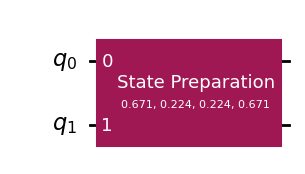

In [5]:

# get amplitudes & normalize
input_ampl = matr.flatten()
input_ampl /= np.linalg.norm(input_ampl)

# number of qubits
n_qubits = int(np.ceil(np.log2(len(input_probs))))
# Pad with zeros if not a power of 2
if 2**n_qubits != len(input_ampl):
    padded_ampl = np.zeros(2**n_qubits)
    padded_ampl[:len(input_ampl)] = input_ampl
    input_ampl = padded_ampl

# Build the circuit
qc = QuantumCircuit(n_qubits, name="Init")
init = StatePreparation(input_ampl)
qc.append(init, qc.qubits)

qc.draw('mpl')

In [6]:
#Check matrix encoding into quantum state
#qc.save_statevector()
qc.measure_all()

In [7]:
# Transpile for simulator
simulator = AerSimulator()
circ = transpile(qc, simulator)

# Run and get counts
result = simulator.run(circ, shots=10000).result()
print(result.get_counts(circ))
#statevector = result.get_statevector(circ)
#print(statevector)
#plot_state_city(statevector, title='Init')

{'00': 4505, '11': 4471, '01': 491, '10': 533}


In [8]:
qc.remove_final_measurements()

### Phase estimation
Step 1: Implementing the unitary operator
For now, let's do the lazy version - that ignores the suggestion of the TRUE qPCA paper (Loyd, Mohseni, Rebentrost 2015), and later we can attempt to implement a realization of their density matrix exponentiation method.

In [9]:
# build exponentiated unitary operator
U = scipy.linalg.expm(1j * matr * 2*np.pi)
U = UnitaryGate(U)

Step 2: Phase estimation

In [10]:
# initialize qiskit PhaseEstimation
resolution = 4 # let's play around with that later
pe = PhaseEstimation(num_evaluation_qubits=resolution, unitary=U, name="PE")
# prepare counting register
n_qubits_register = resolution + n_qubits
pe_register = QuantumRegister(n_qubits_register, "register")
# initialize circuit
pe_circuit = QuantumCircuit(pe_register)
pe_circuit.append(qc, pe_register[resolution:]) # why? don't fully understand that bit
pe_circuit.append(pe.to_gate(), pe_register[:pe.num_qubits])

Let's check if everything is ok up until here by measuring and drawing the circuit:

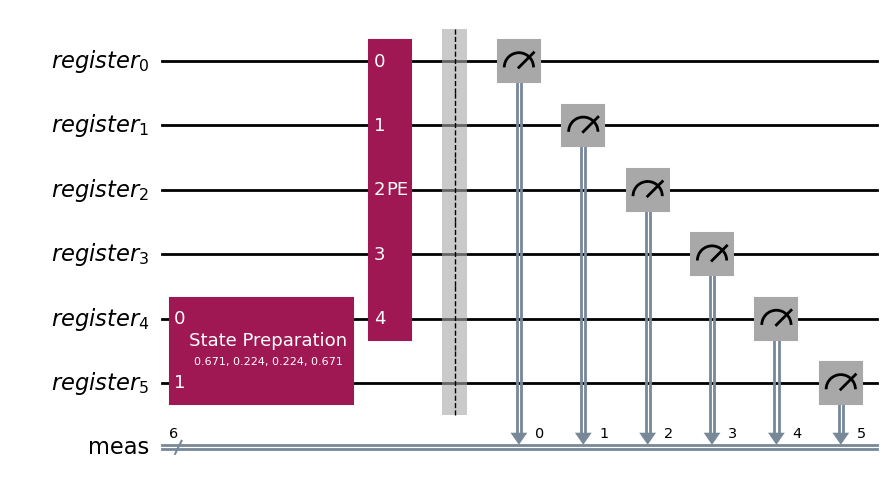

In [11]:
## check statevector
# pe_circuit.save_statevector()
# measure everything
pe_circuit.measure_all()

# draw to check
pe_circuit.decompose(reps=1).draw('mpl')

### Quantum State Tomography
Consists of 2 phases: Probability estimation and Sign estimation

#### Probability estimation
Measure $N$ times, estimate probability $p_i$ of each basis state: 

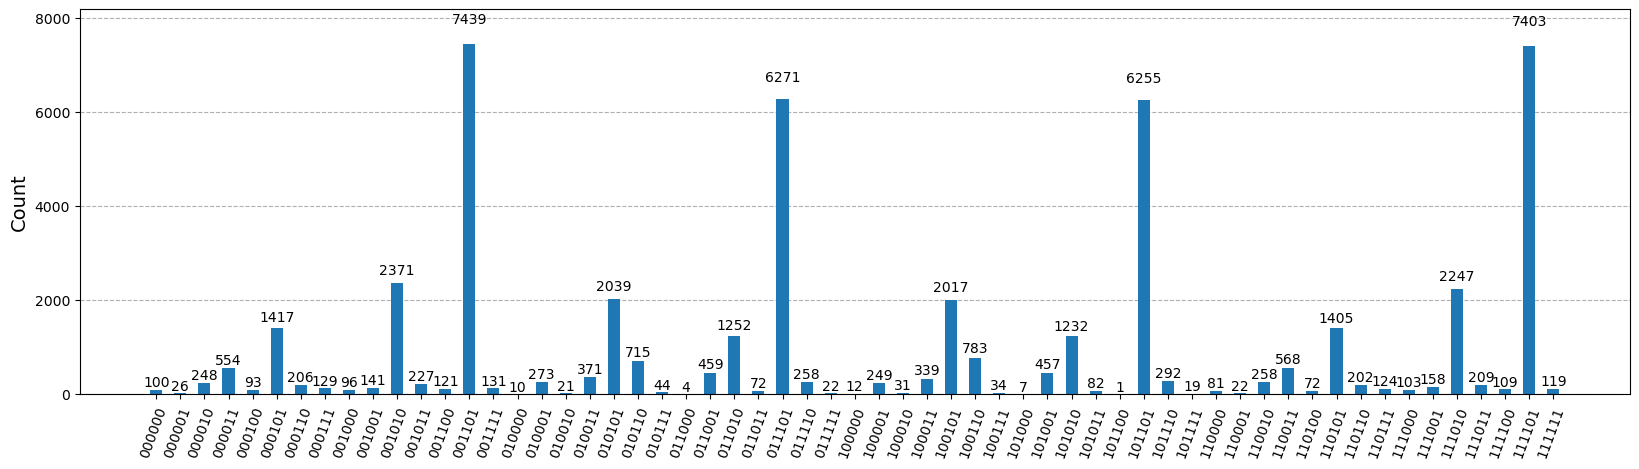

In [12]:
# Run the circuit using Aer simulator
simulator = AerSimulator()
pe_transpiled = transpile(pe_circuit, simulator)

# run with N shots
n_shots = 50000 
pe_result = simulator.run(pe_transpiled, shots=n_shots).result()
pe_counts = pe_result.get_counts()
plot_histogram(pe_counts, figsize=(20, 5))

# check statevector
# statevector = result.get_statevector(pe_transpiled)

In [13]:
# counts dict by default only contains states that were measured at least once
# so here's quick helper function to get zero count states as well
def complete_counts(counts, n_qubits):
    keys = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    return {k: counts.get(k, 0) for k in keys}

In [14]:
# get dictionary with added zero count states 
pe_counts_tot = complete_counts(pe_counts, n_qubits_register)
# estimate probs from counts
probabilities = {state: count / n_shots for state, count in pe_counts_tot.items()}

#### Sign estimation

In [15]:
# adjust PE circuit for sign estimation
pe_circuit.remove_final_measurements() # remove measurements

# prepare unitaries
U_p = StatePreparation(np.sqrt(list(probabilities.values())),label='U_p').control()
# let's hope this works
del pe_circuit.data[0] # this is wonky but ok
U_x_init = init.control()
U_x = pe_circuit.to_gate(label='U_x').control()

In [16]:
# prepare the sign estimation circuit
target_register = QuantumRegister(n_qubits_register, name='Target')
control_register = QuantumRegister(1, name='Control')
se_circuit = QuantumCircuit(target_register, control_register, name='SE')
# add gates
se_circuit.h(control_register)
se_circuit.x(control_register)
se_circuit.append(U_x_init, control_register[:]+target_register[resolution:n_qubits_register])
se_circuit.append(U_x, control_register[:]+target_register[:])
se_circuit.x(control_register)
se_circuit.append(U_p, control_register[:]+target_register[:])
se_circuit.h(control_register)
se_circuit.measure_all()

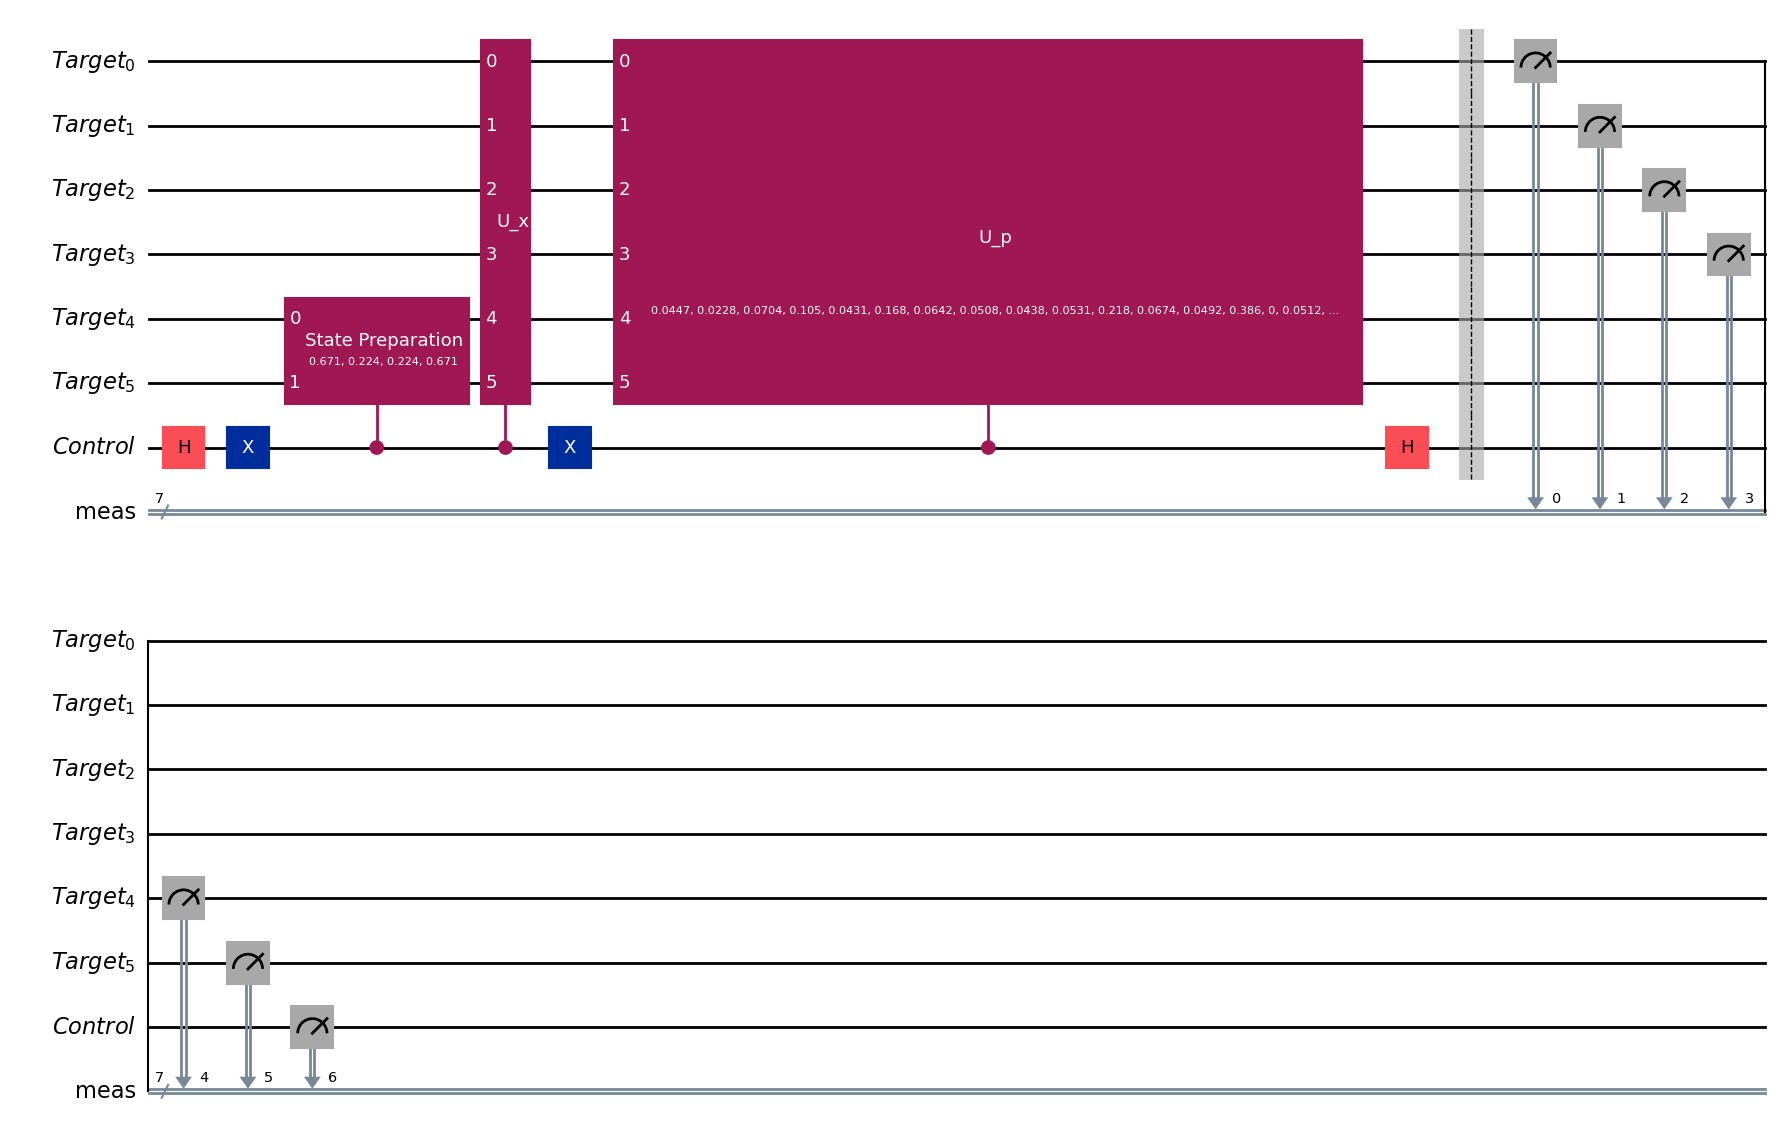

In [17]:
se_circuit.draw('mpl')

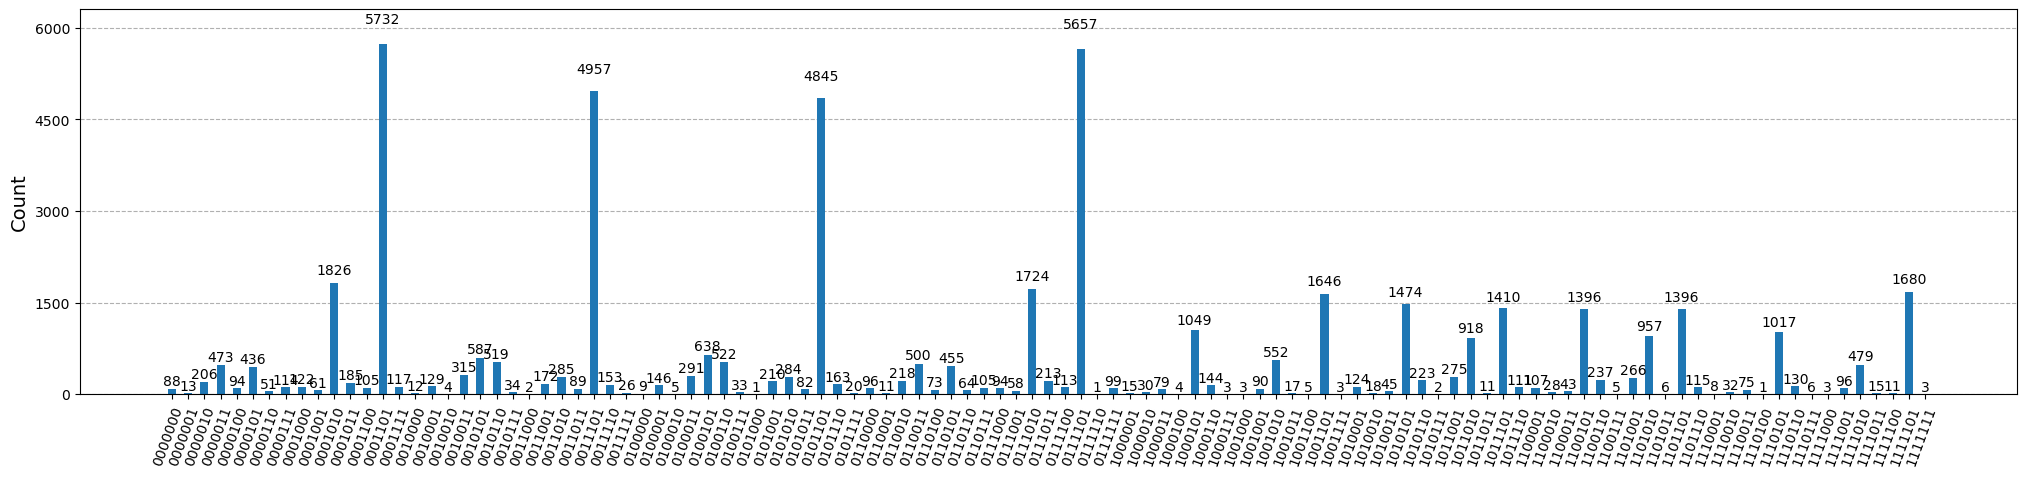

In [18]:
# time to measure!!
# Run the circuit using Aer simulator
se_transpiled = transpile(se_circuit, simulator)

# run with N shots
n_shots = 50000 
se_result = simulator.run(se_transpiled, shots=n_shots).result()
se_counts = se_result.get_counts()
plot_histogram(se_counts, figsize=(25, 5))

In [19]:
# filter for counts with Control qubit equal 0
se_counts_filtered = {state[1:]: counts for state, counts in se_counts.items() if state[0]=='0'}
# pad with zeros?
# not sure if necessary or correct
se_counts_filtered = complete_counts(se_counts_filtered, se_circuit.num_qubits-1)
# compare to find signs:
sign_dict = {}
for state, counts in se_counts_filtered.items():
    if counts > 0.4*n_shots*probabilities[state]:
        sign_dict[state] = 1
    else:
        sign_dict[state] = -1

### Eigenvalue and Eigenvector reconstruction


In [20]:
# how about no pandas?
states = list(probabilities.keys())
lambdas = [s[-resolution:] for s in states]
vectors = [s[:-resolution] for s in states]

# compute eigenvalues
eigvals = np.array([int(l[::-1], base=2) for l in lambdas]) /(2**resolution)
eigvals_unique = np.unique(eigvals)

In [25]:
# initialise lambdas_dict
lambdas_dict = {}
lambdas_signs = {}
for state, probs in probabilities.items():
    lam = state[-resolution:]
    if lam not in lambdas_dict.keys():
        lambdas_dict[lam] = 0.
    lambdas_dict[lam] += probs

# compute eigvals
#eigvals = np.array([int(l[::-1], base=2) for l in lambdas_dict.keys()]) /(2**resolution)

# Convert to sorted list
lambda_keys = sorted(lambdas_dict.keys(), key=lambda x: int(x[::-1], 2))
lambda_probs = np.array([lambdas_dict[k] for k in lambda_keys])

# Find peaks
peaks_idx, _ = find_peaks(lambda_probs, threshold=0.001)
peak_lambda_bits = [lambda_keys[i] for i in peaks_idx]

eigvals = []
eigvecs = []
for lam in peak_lambda_bits:
    # compute and save eigenvalue
    eigval = int(lam[::-1], 2) / 2**resolution
    eigvals.append(eigval)

    # TODO: YOU NEED TO COLLECT ALL STATES AGAIN!!!!!
    relevant_states = [state for state in probabilities if state.endswith(lam)]
    amps = []
    for state in relevant_states:
        prob = probabilities[state]
        sign = sign_dict[state]
        amp = sign * np.sqrt(prob)
        amps.append((state[:-resolution], amp))  # keep only the eigenvector part

    amps.sort(key=lambda x: x[0])  # Sort by basis state
    vec = np.array([amp for _, amp in amps])

    # 5. Normalize the eigenvector
    vec = vec / np.linalg.norm(vec)

    eigvecs.append((eigval, vec))

In [26]:
for val, vec in eigvecs:
    print(val)
    print(vec)

0.3125
[ 0.57779721 -0.41986709 -0.41650001  0.56248533]
0.6875
[0.52135765 0.47868175 0.4780707  0.5200946 ]


Comparing with the func below: eigvals track, but eigvecs are super duper weird (yeah they're too long, still gotta figure that out)

Ok this is kinda weird, let's check what their function spits out:

['1010'] [np.float64(0.3125)]
['1010', '1101'] [np.float64(0.3125), np.float64(0.6875)]
[array([0.21776134, 0.15824032, 0.15697133, 0.21199057]), array([0.38572011, 0.35414686, 0.35369478, 0.38478565])]
[(0.3125, array([ 0.76012973, -0.5523624 ])), (0.6875, array([0.722051  , 0.66294728]))]


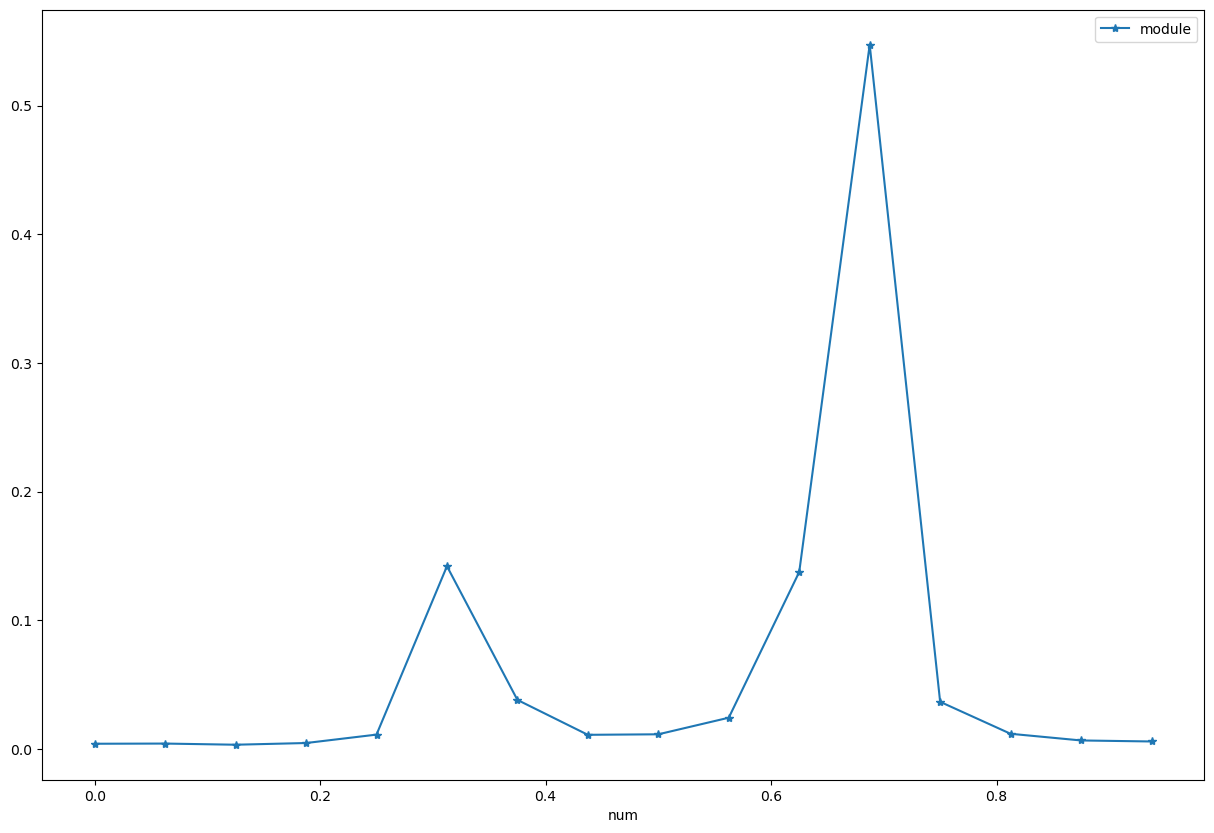

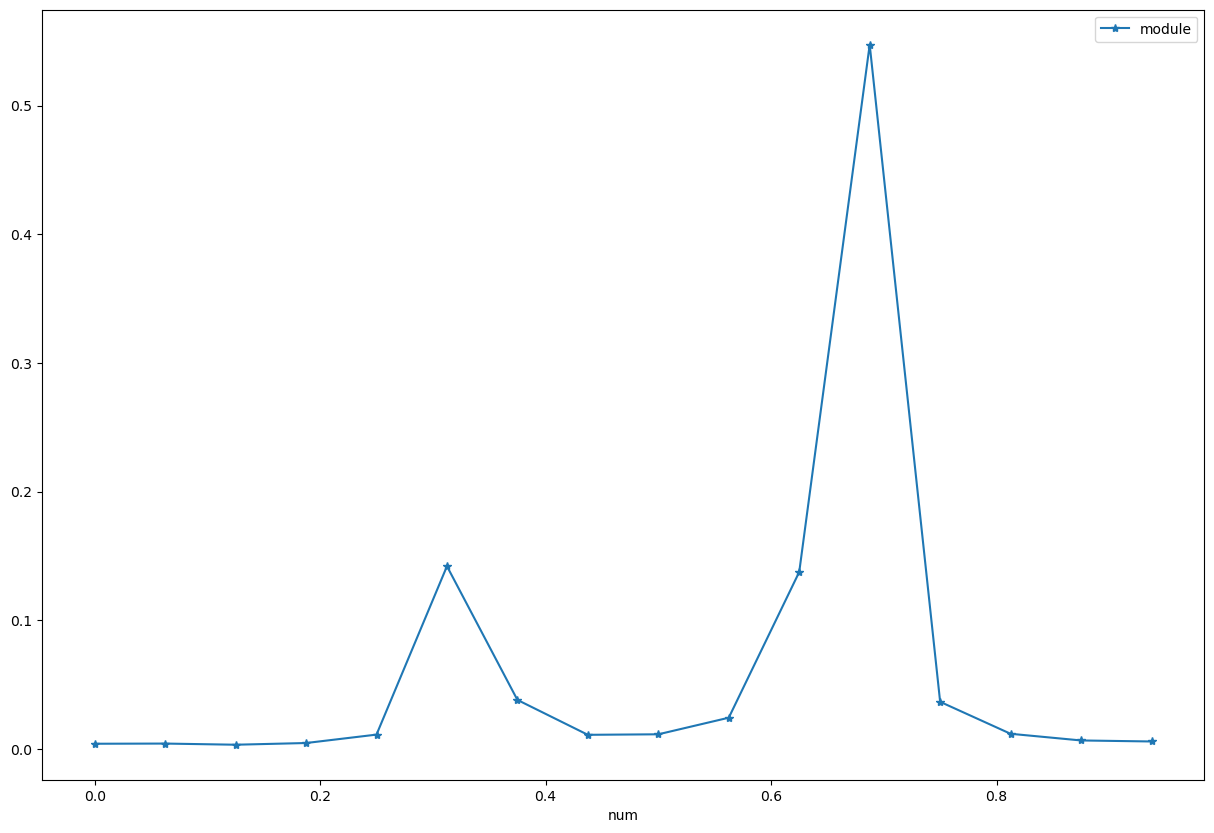

In [24]:
import pandas as pd

df = pd.DataFrame.from_dict(probabilities, orient='index')
df.reset_index(inplace=True)
df.columns=['state', 'module']

df['lambda']=df['state'].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1=df1.sort_values('module',ascending=False)
df1.reset_index(inplace=True)
df1['num']=df1['lambda'].apply(lambda x :int(x[::-1],base=2)/(2**resolution))

peaks=[]
nums_peaks=[]

for i in find_peaks(df1.sort_values(['num'])['module'], threshold=0.001)[0]:
    el = df1.sort_values(['num']).iloc[i]
    nums_peaks.append(el['num'])
    peaks.append(el['lambda'])

    print(peaks, nums_peaks)
    df1[['num','module']].sort_values('num').set_index('num').plot(style='-*',figsize=(15,10))

df.columns=['state','module','lambda']
df['sign']=np.array(list(sign_dict.values()))
df['module']=df['module'].multiply(np.array(list(sign_dict.values())), axis=0)
df=df.fillna(0)

a=[]
save_sign=[]
eigenvalues=[]
for l in peaks:
    eigenvalues.append(int(l[::-1],base=2)/(2**resolution))
    a_=np.array(df.query("state.str.endswith(@l)")['module'].values)
    #print(a_)
    save_sign.append(np.sign(a_))
    #print(save_sign)
    
    a.append(np.sqrt(abs(a_)))

#a=[a1,a2]
print(a)

for i in range(len(a)):
    # print(a[i])
    normalization_factor=np.sqrt((1/(sum(a[i]**2))))
    # print(normalization_factor)
    a[i]*=normalization_factor
    a[i]*=save_sign[i]

len_eigenvector = len(list(probabilities.keys())[0])-resolution
eigenvectors=[]
for ll, eig in zip(a, eigenvalues):
    
    eigenvector=np.zeros(len_eigenvector) #put length of eigenvector
    save_sign=np.sign(ll)
    sv=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(sv), len_eigenvector)):
        max_list.append(max(sv[i:i+len_eigenvector]))
        scaled_statevectors.append(sv[i:i+len_eigenvector]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    #eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[len_eigenvector*idx_max:len_eigenvector*idx_max+len_eigenvector]
    eigenvectors.append((eig, eigenvector))
print(eigenvectors)